In [210]:
import torch
print(torch.__version__)
import numpy as np
import math
import matplotlib.pyplot as plt


2.8.0+cpu


In [211]:
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange ( -5, 5, 0.25)

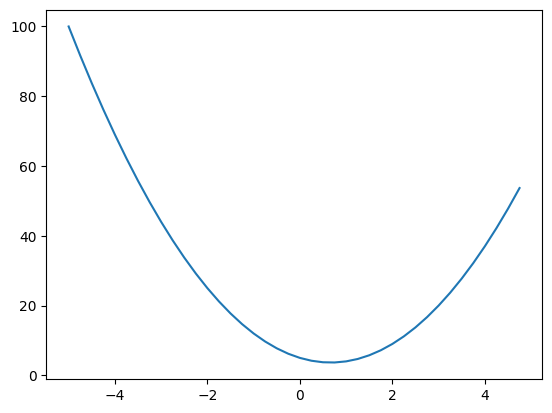

In [212]:
ys = f(xs)
plt.plot(xs, ys)

In [213]:
x = 30
h = 0.0000000000001
(f(x+h)-f(x))/h

172.80399333685637

In [214]:
a = 1.0
b = 2.0
c = 3.0
d = a*b - c
print(d)


-1.0


In [215]:
h = 0.0001

d1 = a*b+c
a+=h
d2 = a*b+c
print('d1:', d1)
print('d2:', d2)
print ('slope:', (d2-d1)/h)

d1: 5.0
d2: 5.0001999999999995
slope: 1.9999999999953388


In [216]:
class Value:
    def __init__(self, data, _children=(), _op=(), label = ''):
        self.data=data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __neg__(self):
        return self*(-1)

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self*other

    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out =  Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other -1))*out.grad
        out._backward = _backward
        return out


    def __truediv__(self, other):
        return self* other**(-1)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1) 
        out =  Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data 
        out =  Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

a = Value(1.0, label = 'a')
b = Value(2.0, label = 'b')
c = Value(3.0, label = 'c')
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Value(-2.0, label='f')
L = e*f
print(L)
print(L._prev)
print(L._op)


Value(data=-10.0)
{Value(data=5.0), Value(data=-2.0)}
*


In [217]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)

In [218]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s |  data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) +n2._op)
    return dot
    

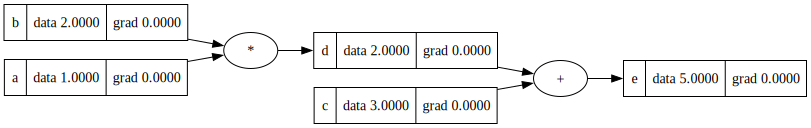

In [219]:
draw_dot(e)


In [220]:
trace(e)


({Value(data=1.0),
  Value(data=2.0),
  Value(data=2.0),
  Value(data=3.0),
  Value(data=5.0)},
 {(Value(data=1.0), Value(data=2.0)),
  (Value(data=2.0), Value(data=2.0)),
  (Value(data=2.0), Value(data=5.0)),
  (Value(data=3.0), Value(data=5.0))})

5.0
-2.0
0.0
0.0
1.0
-2.0


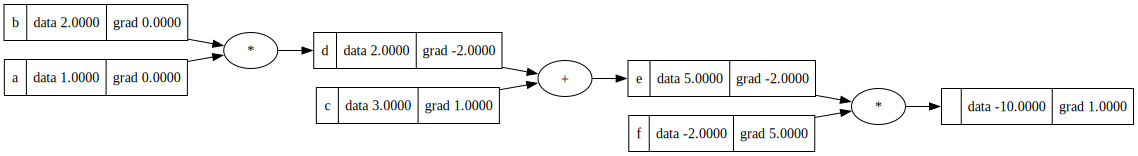

In [221]:
L.grad = 1.0
f.grad = e.data
print(f.grad)
e.grad = f.data
print(e.grad)
a.grad = d.grad*b.data
print(a.grad)
b.grad = d.grad*a.data
print(b.grad)
c.grad = 1.0
print(c.grad)
d.grad = e.grad*1.0
print(d.grad)

draw_dot(L)


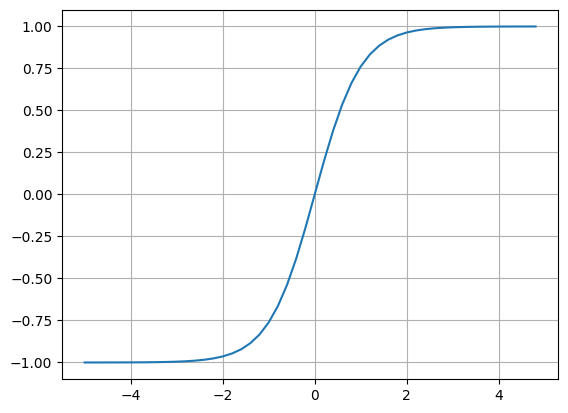

In [222]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [223]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
bias1 = Value(6.8813735870195432, label='bias1')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + bias1; n.label = 'n'

o = n.tanh(); o.label = 'o'


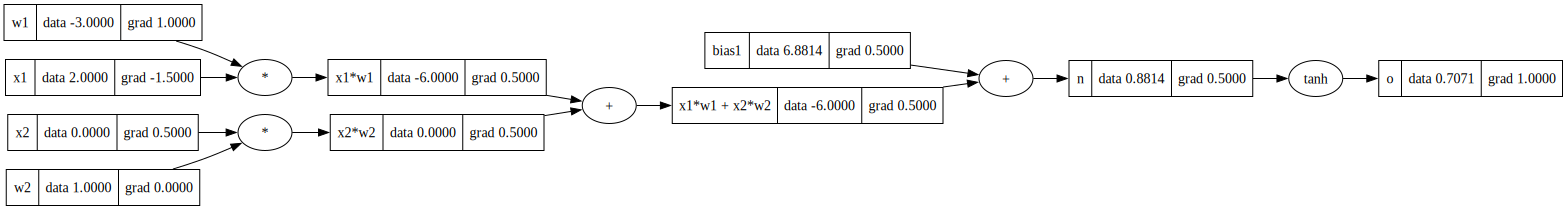

In [224]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
o.grad = 1.0

draw_dot(o)


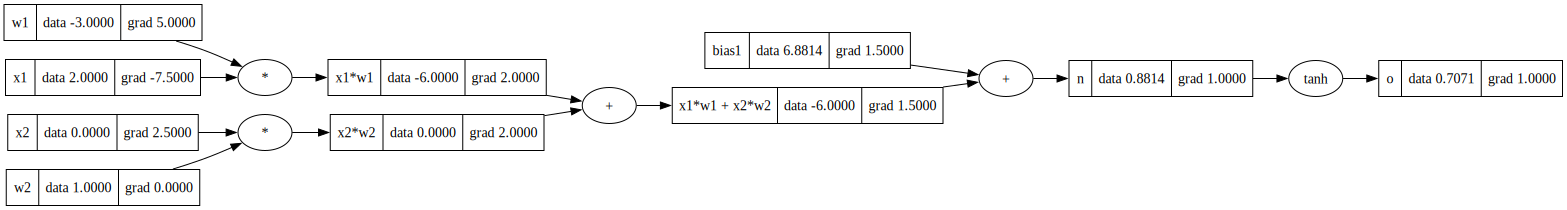

In [225]:
o.backward()
draw_dot(o)

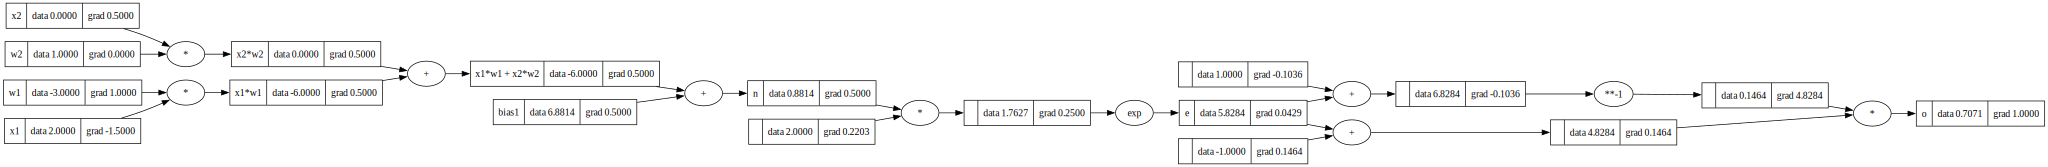

In [226]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
bias1 = Value(6.8813735870195432, label='bias1')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + bias1; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'

o.backward()
draw_dot(o)

In [227]:
import random 
class Neuron: 
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [228]:
x = [1.0, 2.0, 2.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.1556390478756158)

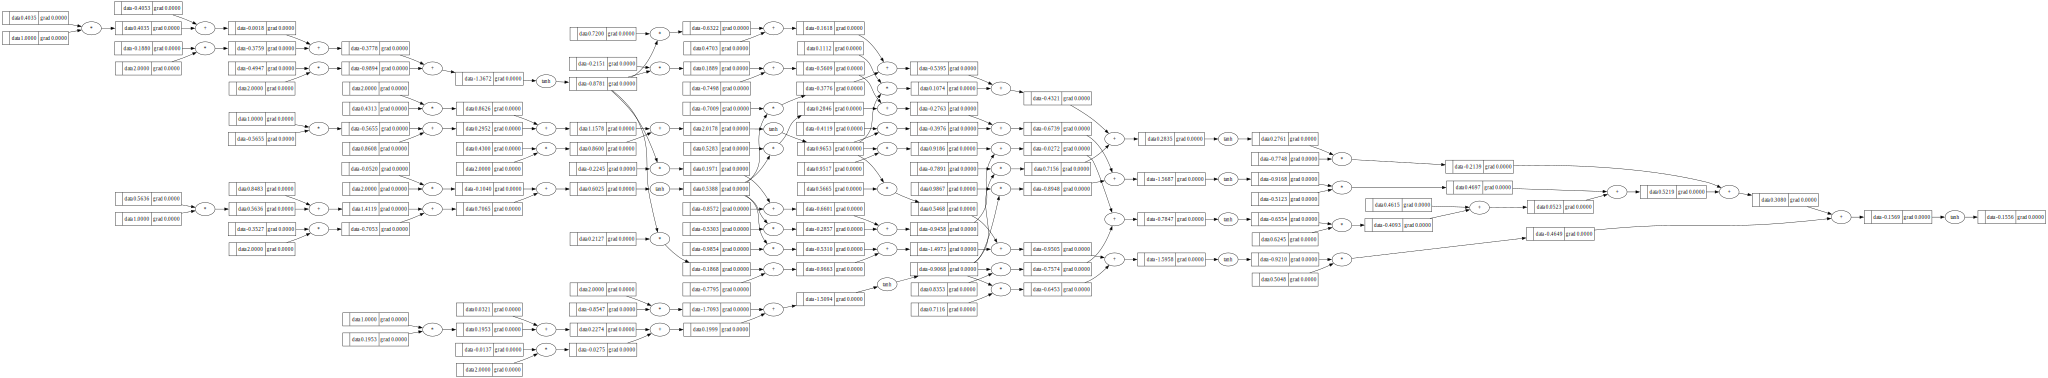

In [229]:
draw_dot(n(x))

In [230]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [239]:
for k in range(60):
  ypred = [n(x) for x in xs]
  loss = Value(0.0)  
  for ygt, yout in zip(ys, ypred):
      loss += (yout - ygt) ** 2

  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  

  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.0063030372927558335
1 0.0061523507544328625
2 0.006008499504813763
3 0.005871034350273529
4 0.005739544355249063
5 0.005613652870328897
6 0.005493014043840188
7 0.005377309749748923
8 0.005266246875138124
9 0.005159554919187784
10 0.005056983862779627
11 0.004958302273860256
12 0.004863295618731052
13 0.004771764753665026
14 0.004683524574820387
15 0.004598402807438609
16 0.004516238917878364
17 0.0044368831342155995
18 0.0043601955630020815
19 0.004286045391366222
20 0.004214310165007459
21 0.004144875133809428
22 0.004077632657812736
23 0.004012481667162232
24 0.003949327170404372
25 0.0038880798061687377
26 0.0038286554338411833
27 0.003770974759337095
28 0.003714962992519219
29 0.0036605495331883224
30 0.0036076676829099913
31 0.003556254380235826
32 0.003506249957137828
33 0.003457597914702705
34 0.0034102447163368143
35 0.0033641395969096592
36 0.0033192343864246977
37 0.003275483346945737
38 0.0032328430216330825
39 0.003191272094855375
40 0.003150731262442524
41 0.003111183

In [240]:
ypred

[Value(data=0.9879158895253589),
 Value(data=-0.9836759130561089),
 Value(data=-0.9653326226011789),
 Value(data=0.969652869593502)]